In [7]:
# Parameters
FUDGE_FACTOR = 0.985  # Multiply forecasts by this
XGB_WEIGHT = 0.3200
BASELINE_WEIGHT = 0.0100
OLS_WEIGHT = 0.0620
NN_WEIGHT = 0.0800
CAT_WEIGHT=0.4000
XGB1_WEIGHT = 0.8000  # Weight of first in combination of two XGB models
BASELINE_PRED = 5.631925   # Baseline based on mean of training data, per Oleg

import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc
from sklearn.linear_model import LinearRegression
import random
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from catboost import CatBoostRegressor
from tqdm import tqdm
from dateutil.parser import parse
###### READ IN RAW DATA
#
print( "\nReading data from disk ...")
data_path = 'datas/'
train = pd.read_csv(data_path+'train.csv',encoding='gb18030')
test = pd.read_csv(data_path+'testA.csv',encoding='gb18030')
#


Reading data from disk ...


In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.layers.noise import GaussianDropout
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [9]:
#
#################
#################
###  LightGBM  ##
#################
#################
#
##### PROCESS DATA FOR LIGHTGBM
print( "\nProcessing data for LightGBM ..." )
def make_feat_lightgbm(train,test):
    train_id = train.id.values.copy()
    test_id = test.id.values.copy()
    data = pd.concat([train,test])
    data['性别'] = data['性别'].map({'男':1,'女':0})
    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days
    data.fillna(data.median(axis=0),inplace=True)

    for c, dtype in zip(data.columns, data.dtypes):

        if dtype == np.float64:

            data[c] = data[c].astype(np.float32)

    

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat

df_train,df_test= make_feat_lightgbm(train,test)

x_train = df_train.drop(['id', '血糖'], axis=1)

y_train = df_train['血糖'].values

print(x_train.shape, y_train.shape)

train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:

    x_train[c] = (x_train[c] == True)

del df_train; gc.collect()

x_train = x_train.values.astype(np.float32, copy=False)

d_train = lgb.Dataset(x_train, label=y_train)

##### RUN LIGHTGBM

params = {}

params['max_bin'] = 10

params['learning_rate'] = 0.0021 # shrinkage_rate

params['boosting_type'] = 'gbdt'

params['objective'] = 'regression'

params['metric'] = 'mse'          # or 'mae'

params['sub_feature'] = 0.345    # feature_fraction (small values => use very different submodels)

params['bagging_fraction'] = 0.85 # sub_row

params['bagging_freq'] = 40

params['num_leaves'] = 512        # num_leaf

params['min_data'] = 500         # min_data_in_leaf

params['min_hessian'] = 0.05     # min_sum_hessian_in_leaf

params['verbose'] = 0

params['feature_fraction_seed'] = 2

params['bagging_seed'] = 3

np.random.seed(0)

random.seed(0)

print("\nFitting LightGBM model ...")

clf = lgb.train(params, d_train, 1000)

del d_train; gc.collect()

del x_train; gc.collect()

print("\nPrepare for LightGBM prediction ...")

print("   Preparing x_test...")

x_test = df_test.drop(['id','血糖'], axis=1)

print("\nStart LightGBM prediction ...")

p_test = clf.predict(x_test)

del x_test; gc.collect()

print( "\nUnadjusted LightGBM predictions:" )

print( pd.DataFrame(p_test).head() )


Processing data for LightGBM ...
(5642, 40) (5642,)

Fitting LightGBM model ...

Prepare for LightGBM prediction ...
   Preparing x_test...

Start LightGBM prediction ...

Unadjusted LightGBM predictions:
          0
0  5.980362
1  6.152404
2  5.434784
3  5.691541
4  5.347017


In [10]:
################

################

##  XGBoost   ##

################

################

#### PROCESS DATA FOR XGBOOST

print( "\nProcessing data for XGBoost ...")

data_path = 'datas/'

train = pd.read_csv(data_path+'train.csv',encoding='gb18030')

test = pd.read_csv(data_path+'testA.csv',encoding='gb18030')

def make_feat_xgb(train,test):

    train_id = train.id.values.copy()

    test_id = test.id.values.copy()

    data = pd.concat([train,test])

    data['性别'] = data['性别'].map({'男':1,'女':0})

    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days

    

    data.fillna(-1,axis=1,inplace=True)

    for c, dtype in zip(data.columns, data.dtypes):

        if dtype == np.float64:

            data[c] = data[c].astype(np.float32)

    

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat

df_train,df_test= make_feat_xgb(train,test)

y_train = df_train['血糖'].values

x_train = df_train.drop(['id', '血糖'], axis=1)

y_mean = np.mean(y_train)

print(x_train.shape, y_train.shape)

x_test = df_test.drop(['id','血糖'], axis=1)

# shape        

print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

##### RUN XGBOOST

print("\nSetting up data for XGBoost ...")

# xgboost params

xgb_params = {

    'eta': 0.037,

    'max_depth': 5,

    'subsample': 0.80,

    'objective': 'reg:linear',

    'eval_metric': 'rmse',

    'lambda': 0.8,   

    'alpha': 0.4, 

    'base_score': y_mean,

    'silent': 1

}

dtrain = xgb.DMatrix(x_train, y_train)

dtest = xgb.DMatrix(x_test)

num_boost_rounds = 250

print("num_boost_rounds="+str(num_boost_rounds))

# train model

print( "\nTraining XGBoost ...")

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost ...")

xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )

print( pd.DataFrame(xgb_pred1).head() )

##### RUN XGBOOST AGAIN

print("\nSetting up data for XGBoost ...")

# xgboost params

xgb_params = {

    'eta': 0.033,

    'max_depth': 6,

    'subsample': 0.80,

    'objective': 'reg:linear',

    'eval_metric': 'rmse',

    'base_score': y_mean,

    'silent': 1

}

num_boost_rounds = 150

print("num_boost_rounds="+str(num_boost_rounds))

print( "\nTraining XGBoost again ...")

model = xgb.train(dict(xgb_params, silent=1), dtrain, num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost again ...")

xgb_pred2 = model.predict(dtest)

print( "\nSecond XGBoost predictions:" )

print( pd.DataFrame(xgb_pred2).head() )

##### COMBINE XGBOOST RESULTS

xgb_pred = XGB1_WEIGHT*xgb_pred1 + (1-XGB1_WEIGHT)*xgb_pred2

#xgb_pred = xgb_pred1

print( "\nCombined XGBoost predictions:" )

print( pd.DataFrame(xgb_pred).head() )

del df_train

del x_train

del x_test

del dtest

del dtrain

del xgb_pred1

del xgb_pred2 

gc.collect()



Processing data for XGBoost ...
(5642, 40) (5642,)
Shape train: (5642, 40)
Shape test: (1000, 40)

Setting up data for XGBoost ...
num_boost_rounds=250

Training XGBoost ...

Predicting with XGBoost ...

First XGBoost predictions:
          0
0  6.104340
1  5.956324
2  5.293948
3  6.435590
4  5.126501

Setting up data for XGBoost ...
num_boost_rounds=150

Training XGBoost again ...

Predicting with XGBoost again ...

Second XGBoost predictions:
          0
0  5.922185
1  5.961242
2  5.154244
3  6.046094
4  5.218094

Combined XGBoost predictions:
          0
0  6.067909
1  5.957308
2  5.266007
3  6.357691
4  5.144819


52

In [11]:



######################

######################

##  Neural Network  ##

######################

######################

# Neural network copied from this script:

# Read in data for neural network

print( "\n\nProcessing data for Neural Network ...")

data_path = 'datas/'

train = pd.read_csv(data_path+'train.csv',encoding='gb18030')

test = pd.read_csv(data_path+'testA.csv',encoding='gb18030')

def make_feat_nn(train,test):

    train_id = train.id.values.copy()

    test_id = test.id.values.copy()

    data = pd.concat([train,test])

    data['性别'] = data['性别'].map({'男':1,'女':0})

    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days

    

    data.fillna(-1,axis=1,inplace=True)

    for c, dtype in zip(data.columns, data.dtypes):

        if dtype == np.float64:

            data[c] = data[c].astype(np.float32)

    

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat

df_train,df_test= make_feat_nn(train,test)

y_train = df_train['血糖'].values

x_train = df_train.drop(['id', '血糖'], axis=1)

print(x_train.shape, y_train.shape)

x_test = df_test.drop(['id','血糖'], axis=1)

# shape        

print('Shape train: {}\nShape test: {}'.format(x_train.shape, x_test.shape))

y_mean = np.mean(y_train)

print(x_train.shape, y_train.shape)

## Preprocessing

print("\nPreprocessing neural network data...")

imputer= Imputer()

imputer.fit(x_train.iloc[:, :])

x_train = imputer.transform(x_train.iloc[:, :])

imputer.fit(x_test.iloc[:, :])

x_test = imputer.transform(x_test.iloc[:, :])

sc = StandardScaler()

x_train = sc.fit_transform(x_train)

x_test = sc.transform(x_test)

len_x=int(x_train.shape[1])

print("len_x is:",len_x)

# Neural Network

print("\nSetting up neural network model...")

nn = Sequential()

nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = len_x))

nn.add(PReLU())

nn.add(Dropout(.4))

nn.add(Dense(units = 160 , kernel_initializer = 'normal'))

nn.add(PReLU())

nn.add(BatchNormalization())

nn.add(Dropout(.6))

nn.add(Dense(units = 64 , kernel_initializer = 'normal'))

nn.add(PReLU())

nn.add(BatchNormalization())

nn.add(Dropout(.5))

nn.add(Dense(units = 26, kernel_initializer = 'normal'))

nn.add(PReLU())

nn.add(BatchNormalization())

nn.add(Dropout(.6))

nn.add(Dense(1, kernel_initializer='normal'))

nn.compile(loss='mae', optimizer=Adam(lr=4e-3, decay=1e-4))

print("\nFitting neural network model...")

nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = 70, verbose=2)

print("\nPredicting with neural network model...")

#print("x_test.shape:",x_test.shape)

y_pred_ann = nn.predict(x_test)

print( "\nPreparing results for write..." )

nn_pred = y_pred_ann.flatten()

print( "Type of nn_pred is ", type(nn_pred) )

print( "Shape of nn_pred is ", nn_pred.shape )

print( "\nNeural Network predictions:" )

print( pd.DataFrame(nn_pred).head() )

# Cleanup
del train
del x_train
del x_test
del df_train
del df_test
del y_pred_ann
gc.collect()



Processing data for Neural Network ...
(5642, 40) (5642,)
Shape train: (5642, 40)
Shape test: (1000, 40)
(5642, 40) (5642,)

Preprocessing neural network data...
len_x is: 40

Setting up neural network model...

Fitting neural network model...
Epoch 1/70
 - 3s - loss: 3.3633
Epoch 2/70
 - 1s - loss: 1.4904
Epoch 3/70
 - 1s - loss: 1.3030
Epoch 4/70
 - 1s - loss: 1.2216
Epoch 5/70
 - 1s - loss: 1.1553
Epoch 6/70
 - 1s - loss: 1.1074
Epoch 7/70
 - 1s - loss: 1.0419
Epoch 8/70
 - 1s - loss: 1.0083
Epoch 9/70
 - 1s - loss: 0.9469
Epoch 10/70
 - 1s - loss: 0.9212
Epoch 11/70
 - 1s - loss: 0.8816
Epoch 12/70
 - 1s - loss: 0.8467
Epoch 13/70
 - 1s - loss: 0.8184
Epoch 14/70
 - 1s - loss: 0.7985
Epoch 15/70
 - 1s - loss: 0.7696
Epoch 16/70
 - 1s - loss: 0.7534
Epoch 17/70
 - 1s - loss: 0.7418
Epoch 18/70
 - 1s - loss: 0.7255
Epoch 19/70
 - 1s - loss: 0.7230
Epoch 20/70
 - 1s - loss: 0.7141
Epoch 21/70
 - 1s - loss: 0.7081
Epoch 22/70
 - 1s - loss: 0.7102
Epoch 23/70
 - 1s - loss: 0.6980
Epoc

21675

In [12]:
################

################

## catboost   ##

################

################

data_path = 'datas/'

train = pd.read_csv(data_path+'train.csv',encoding='gb18030')

test = pd.read_csv(data_path+'testA.csv',encoding='gb18030')

def make_feat_cat(train,test):

    train_id = train.id.values.copy()

    test_id = test.id.values.copy()

    data = pd.concat([train,test])

    data['性别'] = data['性别'].map({'男':1,'女':0})

    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days

    

#    data.fillna(data.median(axis=0),inplace=True)

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat

train_df,test_df = make_feat_cat(train,test)

print('Remove missing data fields ...')

missing_perc_thresh = 0.98

exclude_missing = []

num_rows = train_df.shape[0]

for c in train_df.columns:

    num_missing = train_df[c].isnull().sum()

    if num_missing == 0:

        continue

    missing_frac = num_missing / float(num_rows)

    if missing_frac > missing_perc_thresh:

        exclude_missing.append(c)

print("We exclude: %s" % len(exclude_missing))

del num_rows, missing_perc_thresh

gc.collect();

print ("Remove features with one unique value !!")

exclude_unique = []

for c in train_df.columns:

    num_uniques = len(train_df[c].unique())

    if train_df[c].isnull().sum() != 0:

        num_uniques -= 1

    if num_uniques == 1:

        exclude_unique.append(c)

print("We exclude: %s" % len(exclude_unique))

print ("Define training features !!")

exclude_other = ['id','血糖','乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原', '乙肝e抗体', '乙肝核心抗体']

train_features = []

for c in train_df.columns:

    if c not in exclude_missing and c not in exclude_other and c not in exclude_unique:

        train_features.append(c)

print("We use these for training: %s" % len(train_features))

print ("Define categorial features !!")

cat_feature_inds = []

cat_unique_thresh = 10

for i, c in enumerate(train_features):

    num_uniques = len(train_df[c].unique())

    if num_uniques < cat_unique_thresh:

        cat_feature_inds.append(i)

        

print("Cat features are: %s" % [train_features[ind] for ind in cat_feature_inds])

print ("Replacing NaN values by -999 !!")

train_df.fillna(-999, inplace=True)

test_df.fillna(-999, inplace=True)

print ("Training time !!")

X_train = train_df[train_features]

y_train = train_df['血糖']

print(X_train.shape, y_train.shape)

X_test = test_df[train_features]

print(X_test.shape)

num_ensembles = 5

y_pred_cat = 0.0

for i in tqdm(range(num_ensembles)):

    model = CatBoostRegressor(

        iterations=1000, learning_rate=0.03,

        depth=6, l2_leaf_reg=3, 

        loss_function='RMSE',

        eval_metric='RMSE',

        random_seed=i)

    model.fit(

        X_train, y_train,

        cat_features=cat_feature_inds)

    y_pred_cat += model.predict(X_test)

y_pred_cat /= num_ensembles

del train

del test

gc.collect()

Remove missing data fields ...
We exclude: 0
Remove features with one unique value !!
We exclude: 0
Define training features !!
We use these for training: 35
Define categorial features !!
Cat features are: ['性别']
Replacing NaN values by -999 !!
Training time !!
(5642, 35) (5642,)
(1000, 35)


  0%|          | 0/5 [00:00<?, ?it/s]

0:	learn: 5.6777629	total: 69.8ms	remaining: 1m 9s
1:	learn: 5.5222949	total: 97.6ms	remaining: 48.7s
2:	learn: 5.3706661	total: 136ms	remaining: 45.2s
3:	learn: 5.2231316	total: 146ms	remaining: 36.4s
4:	learn: 5.0814116	total: 182ms	remaining: 36.2s
5:	learn: 4.9450959	total: 215ms	remaining: 35.7s
6:	learn: 4.8116766	total: 244ms	remaining: 34.7s
7:	learn: 4.6838854	total: 274ms	remaining: 34s
8:	learn: 4.5598340	total: 308ms	remaining: 33.9s
9:	learn: 4.4397509	total: 342ms	remaining: 33.8s
10:	learn: 4.3240735	total: 372ms	remaining: 33.4s
11:	learn: 4.2116977	total: 400ms	remaining: 32.9s
12:	learn: 4.1032089	total: 439ms	remaining: 33.3s
13:	learn: 3.9980552	total: 468ms	remaining: 32.9s
14:	learn: 3.8962414	total: 497ms	remaining: 32.6s
15:	learn: 3.7979663	total: 526ms	remaining: 32.4s
16:	learn: 3.7038877	total: 562ms	remaining: 32.5s
17:	learn: 3.6127860	total: 592ms	remaining: 32.3s
18:	learn: 3.5239875	total: 596ms	remaining: 30.8s
19:	learn: 3.4385024	total: 625ms	remaini

161:	learn: 1.3497631	total: 4.6s	remaining: 23.8s
162:	learn: 1.3481257	total: 4.64s	remaining: 23.8s
163:	learn: 1.3461087	total: 4.67s	remaining: 23.8s
164:	learn: 1.3448878	total: 4.7s	remaining: 23.8s
165:	learn: 1.3439684	total: 4.73s	remaining: 23.8s
166:	learn: 1.3428946	total: 4.77s	remaining: 23.8s
167:	learn: 1.3418103	total: 4.8s	remaining: 23.8s
168:	learn: 1.3411740	total: 4.84s	remaining: 23.8s
169:	learn: 1.3400831	total: 4.87s	remaining: 23.8s
170:	learn: 1.3379987	total: 4.9s	remaining: 23.7s
171:	learn: 1.3366895	total: 4.93s	remaining: 23.8s
172:	learn: 1.3342010	total: 4.97s	remaining: 23.8s
173:	learn: 1.3333141	total: 5.01s	remaining: 23.8s
174:	learn: 1.3321017	total: 5.04s	remaining: 23.8s
175:	learn: 1.3307237	total: 5.07s	remaining: 23.7s
176:	learn: 1.3296003	total: 5.1s	remaining: 23.7s
177:	learn: 1.3285596	total: 5.13s	remaining: 23.7s
178:	learn: 1.3268801	total: 5.16s	remaining: 23.7s
179:	learn: 1.3250803	total: 5.2s	remaining: 23.7s
180:	learn: 1.3243

320:	learn: 1.2000251	total: 9.26s	remaining: 19.6s
321:	learn: 1.1992734	total: 9.29s	remaining: 19.6s
322:	learn: 1.1985548	total: 9.31s	remaining: 19.5s
323:	learn: 1.1975108	total: 9.35s	remaining: 19.5s
324:	learn: 1.1970245	total: 9.37s	remaining: 19.5s
325:	learn: 1.1963860	total: 9.4s	remaining: 19.4s
326:	learn: 1.1956182	total: 9.43s	remaining: 19.4s
327:	learn: 1.1953570	total: 9.45s	remaining: 19.4s
328:	learn: 1.1940859	total: 9.48s	remaining: 19.3s
329:	learn: 1.1926878	total: 9.51s	remaining: 19.3s
330:	learn: 1.1920878	total: 9.54s	remaining: 19.3s
331:	learn: 1.1913463	total: 9.57s	remaining: 19.3s
332:	learn: 1.1908885	total: 9.6s	remaining: 19.2s
333:	learn: 1.1894964	total: 9.63s	remaining: 19.2s
334:	learn: 1.1888659	total: 9.66s	remaining: 19.2s
335:	learn: 1.1881936	total: 9.68s	remaining: 19.1s
336:	learn: 1.1874547	total: 9.71s	remaining: 19.1s
337:	learn: 1.1868850	total: 9.74s	remaining: 19.1s
338:	learn: 1.1858287	total: 9.77s	remaining: 19s
339:	learn: 1.18

479:	learn: 1.1017994	total: 13.6s	remaining: 14.8s
480:	learn: 1.1012132	total: 13.7s	remaining: 14.8s
481:	learn: 1.1009449	total: 13.7s	remaining: 14.7s
482:	learn: 1.1004975	total: 13.7s	remaining: 14.7s
483:	learn: 1.1003421	total: 13.8s	remaining: 14.7s
484:	learn: 1.0997560	total: 13.8s	remaining: 14.6s
485:	learn: 1.0992636	total: 13.8s	remaining: 14.6s
486:	learn: 1.0988718	total: 13.8s	remaining: 14.6s
487:	learn: 1.0986737	total: 13.9s	remaining: 14.5s
488:	learn: 1.0978982	total: 13.9s	remaining: 14.5s
489:	learn: 1.0973118	total: 13.9s	remaining: 14.5s
490:	learn: 1.0967405	total: 13.9s	remaining: 14.5s
491:	learn: 1.0962500	total: 14s	remaining: 14.4s
492:	learn: 1.0955614	total: 14s	remaining: 14.4s
493:	learn: 1.0949983	total: 14s	remaining: 14.4s
494:	learn: 1.0944125	total: 14.1s	remaining: 14.3s
495:	learn: 1.0939938	total: 14.1s	remaining: 14.3s
496:	learn: 1.0938617	total: 14.1s	remaining: 14.3s
497:	learn: 1.0935229	total: 14.1s	remaining: 14.3s
498:	learn: 1.0934

638:	learn: 1.0368393	total: 18s	remaining: 10.2s
639:	learn: 1.0360700	total: 18s	remaining: 10.1s
640:	learn: 1.0358729	total: 18s	remaining: 10.1s
641:	learn: 1.0356702	total: 18.1s	remaining: 10.1s
642:	learn: 1.0354697	total: 18.1s	remaining: 10s
643:	learn: 1.0348899	total: 18.1s	remaining: 10s
644:	learn: 1.0343737	total: 18.1s	remaining: 9.98s
645:	learn: 1.0340701	total: 18.2s	remaining: 9.95s
646:	learn: 1.0338396	total: 18.2s	remaining: 9.92s
647:	learn: 1.0336718	total: 18.2s	remaining: 9.9s
648:	learn: 1.0333500	total: 18.2s	remaining: 9.87s
649:	learn: 1.0330256	total: 18.3s	remaining: 9.84s
650:	learn: 1.0328640	total: 18.3s	remaining: 9.81s
651:	learn: 1.0321364	total: 18.3s	remaining: 9.78s
652:	learn: 1.0317209	total: 18.3s	remaining: 9.75s
653:	learn: 1.0313647	total: 18.4s	remaining: 9.72s
654:	learn: 1.0309964	total: 18.4s	remaining: 9.7s
655:	learn: 1.0304804	total: 18.4s	remaining: 9.67s
656:	learn: 1.0299415	total: 18.5s	remaining: 9.64s
657:	learn: 1.0296391	to

797:	learn: 0.9844480	total: 22.3s	remaining: 5.65s
798:	learn: 0.9841206	total: 22.4s	remaining: 5.62s
799:	learn: 0.9839031	total: 22.4s	remaining: 5.59s
800:	learn: 0.9835827	total: 22.4s	remaining: 5.57s
801:	learn: 0.9834021	total: 22.4s	remaining: 5.54s
802:	learn: 0.9830662	total: 22.5s	remaining: 5.51s
803:	learn: 0.9829414	total: 22.5s	remaining: 5.48s
804:	learn: 0.9829170	total: 22.5s	remaining: 5.45s
805:	learn: 0.9824702	total: 22.5s	remaining: 5.42s
806:	learn: 0.9824554	total: 22.6s	remaining: 5.39s
807:	learn: 0.9822589	total: 22.6s	remaining: 5.37s
808:	learn: 0.9820161	total: 22.6s	remaining: 5.34s
809:	learn: 0.9818737	total: 22.6s	remaining: 5.31s
810:	learn: 0.9814132	total: 22.7s	remaining: 5.28s
811:	learn: 0.9810349	total: 22.7s	remaining: 5.25s
812:	learn: 0.9807155	total: 22.7s	remaining: 5.22s
813:	learn: 0.9805391	total: 22.7s	remaining: 5.2s
814:	learn: 0.9800690	total: 22.8s	remaining: 5.17s
815:	learn: 0.9798272	total: 22.8s	remaining: 5.14s
816:	learn: 0

956:	learn: 0.9463192	total: 26.7s	remaining: 1.2s
957:	learn: 0.9460108	total: 26.7s	remaining: 1.17s
958:	learn: 0.9459292	total: 26.7s	remaining: 1.14s
959:	learn: 0.9458378	total: 26.8s	remaining: 1.11s
960:	learn: 0.9455710	total: 26.8s	remaining: 1.09s
961:	learn: 0.9446828	total: 26.8s	remaining: 1.06s
962:	learn: 0.9445954	total: 26.8s	remaining: 1.03s
963:	learn: 0.9443165	total: 26.9s	remaining: 1s
964:	learn: 0.9441910	total: 26.9s	remaining: 975ms
965:	learn: 0.9440622	total: 26.9s	remaining: 947ms
966:	learn: 0.9438844	total: 26.9s	remaining: 919ms
967:	learn: 0.9438120	total: 27s	remaining: 891ms
968:	learn: 0.9434813	total: 27s	remaining: 863ms
969:	learn: 0.9432072	total: 27s	remaining: 835ms
970:	learn: 0.9431554	total: 27s	remaining: 808ms
971:	learn: 0.9430468	total: 27.1s	remaining: 780ms
972:	learn: 0.9428762	total: 27.1s	remaining: 752ms
973:	learn: 0.9418394	total: 27.1s	remaining: 724ms
974:	learn: 0.9417106	total: 27.1s	remaining: 696ms
975:	learn: 0.9413420	to

 20%|██        | 1/5 [00:29<01:58, 29.73s/it]

0:	learn: 5.6776508	total: 21.6ms	remaining: 21.6s
1:	learn: 5.5212089	total: 47.2ms	remaining: 23.6s
2:	learn: 5.3697531	total: 80.8ms	remaining: 26.8s
3:	learn: 5.2231686	total: 111ms	remaining: 27.7s
4:	learn: 5.0813260	total: 137ms	remaining: 27.3s
5:	learn: 4.9441489	total: 161ms	remaining: 26.7s
6:	learn: 4.8115398	total: 193ms	remaining: 27.3s
7:	learn: 4.6843153	total: 219ms	remaining: 27.1s
8:	learn: 4.5618245	total: 245ms	remaining: 27s
9:	learn: 4.4417308	total: 275ms	remaining: 27.2s
10:	learn: 4.3269461	total: 298ms	remaining: 26.8s
11:	learn: 4.2141318	total: 323ms	remaining: 26.6s
12:	learn: 4.1053520	total: 355ms	remaining: 26.9s
13:	learn: 4.0018727	total: 381ms	remaining: 26.8s
14:	learn: 3.9012695	total: 406ms	remaining: 26.7s
15:	learn: 3.8027830	total: 436ms	remaining: 26.8s
16:	learn: 3.7083235	total: 456ms	remaining: 26.4s
17:	learn: 3.6178486	total: 482ms	remaining: 26.3s
18:	learn: 3.5292214	total: 507ms	remaining: 26.2s
19:	learn: 3.4442185	total: 536ms	remain

161:	learn: 1.3536262	total: 4.21s	remaining: 21.8s
162:	learn: 1.3529923	total: 4.24s	remaining: 21.8s
163:	learn: 1.3519502	total: 4.26s	remaining: 21.7s
164:	learn: 1.3513872	total: 4.29s	remaining: 21.7s
165:	learn: 1.3505434	total: 4.31s	remaining: 21.7s
166:	learn: 1.3497770	total: 4.34s	remaining: 21.6s
167:	learn: 1.3487971	total: 4.37s	remaining: 21.7s
168:	learn: 1.3479886	total: 4.4s	remaining: 21.6s
169:	learn: 1.3470030	total: 4.43s	remaining: 21.6s
170:	learn: 1.3443736	total: 4.46s	remaining: 21.6s
171:	learn: 1.3426638	total: 4.48s	remaining: 21.6s
172:	learn: 1.3412969	total: 4.51s	remaining: 21.6s
173:	learn: 1.3406549	total: 4.54s	remaining: 21.5s
174:	learn: 1.3397667	total: 4.56s	remaining: 21.5s
175:	learn: 1.3388153	total: 4.59s	remaining: 21.5s
176:	learn: 1.3376172	total: 4.62s	remaining: 21.5s
177:	learn: 1.3373405	total: 4.65s	remaining: 21.5s
178:	learn: 1.3364653	total: 4.67s	remaining: 21.4s
179:	learn: 1.3356105	total: 4.7s	remaining: 21.4s
180:	learn: 1.

320:	learn: 1.2110307	total: 8.56s	remaining: 18.1s
321:	learn: 1.2104654	total: 8.6s	remaining: 18.1s
322:	learn: 1.2094370	total: 8.62s	remaining: 18.1s
323:	learn: 1.2081176	total: 8.65s	remaining: 18s
324:	learn: 1.2077148	total: 8.68s	remaining: 18s
325:	learn: 1.2068357	total: 8.7s	remaining: 18s
326:	learn: 1.2057076	total: 8.73s	remaining: 18s
327:	learn: 1.2054157	total: 8.76s	remaining: 17.9s
328:	learn: 1.2048466	total: 8.78s	remaining: 17.9s
329:	learn: 1.2039586	total: 8.81s	remaining: 17.9s
330:	learn: 1.2033408	total: 8.84s	remaining: 17.9s
331:	learn: 1.2028211	total: 8.87s	remaining: 17.8s
332:	learn: 1.2019814	total: 8.89s	remaining: 17.8s
333:	learn: 1.2011370	total: 8.92s	remaining: 17.8s
334:	learn: 1.2004499	total: 8.95s	remaining: 17.8s
335:	learn: 1.1994211	total: 8.97s	remaining: 17.7s
336:	learn: 1.1988511	total: 9s	remaining: 17.7s
337:	learn: 1.1985244	total: 9.03s	remaining: 17.7s
338:	learn: 1.1981333	total: 9.05s	remaining: 17.7s
339:	learn: 1.1971703	tot

479:	learn: 1.1048474	total: 13s	remaining: 14.1s
480:	learn: 1.1040827	total: 13s	remaining: 14.1s
481:	learn: 1.1036792	total: 13.1s	remaining: 14s
482:	learn: 1.1033007	total: 13.1s	remaining: 14s
483:	learn: 1.1031250	total: 13.1s	remaining: 14s
484:	learn: 1.1022593	total: 13.2s	remaining: 14s
485:	learn: 1.1019213	total: 13.2s	remaining: 13.9s
486:	learn: 1.1010562	total: 13.2s	remaining: 13.9s
487:	learn: 1.1003433	total: 13.2s	remaining: 13.9s
488:	learn: 1.0998177	total: 13.3s	remaining: 13.9s
489:	learn: 1.0996319	total: 13.3s	remaining: 13.8s
490:	learn: 1.0991873	total: 13.3s	remaining: 13.8s
491:	learn: 1.0985862	total: 13.3s	remaining: 13.8s
492:	learn: 1.0982781	total: 13.4s	remaining: 13.8s
493:	learn: 1.0979359	total: 13.4s	remaining: 13.7s
494:	learn: 1.0975543	total: 13.4s	remaining: 13.7s
495:	learn: 1.0968413	total: 13.5s	remaining: 13.7s
496:	learn: 1.0964301	total: 13.5s	remaining: 13.6s
497:	learn: 1.0955628	total: 13.5s	remaining: 13.6s
498:	learn: 1.0952134	to

638:	learn: 1.0337951	total: 17.5s	remaining: 9.91s
639:	learn: 1.0332271	total: 17.6s	remaining: 9.88s
640:	learn: 1.0329063	total: 17.6s	remaining: 9.86s
641:	learn: 1.0328281	total: 17.6s	remaining: 9.83s
642:	learn: 1.0324694	total: 17.7s	remaining: 9.81s
643:	learn: 1.0321758	total: 17.7s	remaining: 9.78s
644:	learn: 1.0319330	total: 17.7s	remaining: 9.76s
645:	learn: 1.0311927	total: 17.8s	remaining: 9.73s
646:	learn: 1.0306199	total: 17.8s	remaining: 9.7s
647:	learn: 1.0303098	total: 17.8s	remaining: 9.68s
648:	learn: 1.0301570	total: 17.8s	remaining: 9.65s
649:	learn: 1.0296179	total: 17.9s	remaining: 9.62s
650:	learn: 1.0294804	total: 17.9s	remaining: 9.59s
651:	learn: 1.0290248	total: 17.9s	remaining: 9.56s
652:	learn: 1.0288575	total: 17.9s	remaining: 9.54s
653:	learn: 1.0284849	total: 18s	remaining: 9.51s
654:	learn: 1.0282411	total: 18s	remaining: 9.48s
655:	learn: 1.0276616	total: 18s	remaining: 9.46s
656:	learn: 1.0275672	total: 18.1s	remaining: 9.43s
657:	learn: 1.02735

797:	learn: 0.9804931	total: 22.2s	remaining: 5.61s
798:	learn: 0.9802270	total: 22.2s	remaining: 5.58s
799:	learn: 0.9800791	total: 22.2s	remaining: 5.56s
800:	learn: 0.9795477	total: 22.3s	remaining: 5.53s
801:	learn: 0.9794034	total: 22.3s	remaining: 5.5s
802:	learn: 0.9790183	total: 22.3s	remaining: 5.47s
803:	learn: 0.9788940	total: 22.3s	remaining: 5.45s
804:	learn: 0.9786879	total: 22.4s	remaining: 5.42s
805:	learn: 0.9783315	total: 22.4s	remaining: 5.39s
806:	learn: 0.9779055	total: 22.4s	remaining: 5.36s
807:	learn: 0.9774760	total: 22.5s	remaining: 5.34s
808:	learn: 0.9772375	total: 22.5s	remaining: 5.31s
809:	learn: 0.9770503	total: 22.5s	remaining: 5.28s
810:	learn: 0.9767844	total: 22.5s	remaining: 5.25s
811:	learn: 0.9766387	total: 22.6s	remaining: 5.22s
812:	learn: 0.9764254	total: 22.6s	remaining: 5.2s
813:	learn: 0.9761301	total: 22.6s	remaining: 5.17s
814:	learn: 0.9757930	total: 22.6s	remaining: 5.14s
815:	learn: 0.9754968	total: 22.7s	remaining: 5.11s
816:	learn: 0.

956:	learn: 0.9378580	total: 26.8s	remaining: 1.2s
957:	learn: 0.9375666	total: 26.8s	remaining: 1.17s
958:	learn: 0.9373670	total: 26.8s	remaining: 1.15s
959:	learn: 0.9369724	total: 26.9s	remaining: 1.12s
960:	learn: 0.9366047	total: 26.9s	remaining: 1.09s
961:	learn: 0.9363590	total: 26.9s	remaining: 1.06s
962:	learn: 0.9362514	total: 26.9s	remaining: 1.03s
963:	learn: 0.9360799	total: 27s	remaining: 1.01s
964:	learn: 0.9357098	total: 27s	remaining: 979ms
965:	learn: 0.9353243	total: 27s	remaining: 951ms
966:	learn: 0.9350011	total: 27s	remaining: 922ms
967:	learn: 0.9343580	total: 27.1s	remaining: 894ms
968:	learn: 0.9340313	total: 27.1s	remaining: 866ms
969:	learn: 0.9337918	total: 27.1s	remaining: 838ms
970:	learn: 0.9333373	total: 27.1s	remaining: 810ms
971:	learn: 0.9331242	total: 27.2s	remaining: 782ms
972:	learn: 0.9327635	total: 27.2s	remaining: 754ms
973:	learn: 0.9325755	total: 27.2s	remaining: 727ms
974:	learn: 0.9323339	total: 27.2s	remaining: 699ms
975:	learn: 0.9320399

 40%|████      | 2/5 [00:59<01:29, 29.78s/it]

0:	learn: 5.6777499	total: 17.6ms	remaining: 17.6s
1:	learn: 5.5203298	total: 27.1ms	remaining: 13.5s
2:	learn: 5.3680182	total: 34.3ms	remaining: 11.4s
3:	learn: 5.2221205	total: 59.9ms	remaining: 14.9s
4:	learn: 5.0811768	total: 83.9ms	remaining: 16.7s
5:	learn: 4.9435354	total: 111ms	remaining: 18.3s
6:	learn: 4.8118750	total: 133ms	remaining: 18.9s
7:	learn: 4.6846313	total: 158ms	remaining: 19.6s
8:	learn: 4.5605019	total: 185ms	remaining: 20.4s
9:	learn: 4.4408063	total: 211ms	remaining: 20.9s
10:	learn: 4.3248775	total: 236ms	remaining: 21.2s
11:	learn: 4.2128090	total: 266ms	remaining: 21.9s
12:	learn: 4.1042034	total: 291ms	remaining: 22.1s
13:	learn: 3.9992379	total: 315ms	remaining: 22.2s
14:	learn: 3.8973667	total: 340ms	remaining: 22.3s
15:	learn: 3.7987599	total: 347ms	remaining: 21.4s
16:	learn: 3.7040473	total: 376ms	remaining: 21.7s
17:	learn: 3.6126798	total: 401ms	remaining: 21.9s
18:	learn: 3.5252080	total: 431ms	remaining: 22.3s
19:	learn: 3.4394645	total: 441ms	re

161:	learn: 1.3572023	total: 4.08s	remaining: 21.1s
162:	learn: 1.3538194	total: 4.11s	remaining: 21.1s
163:	learn: 1.3524278	total: 4.13s	remaining: 21.1s
164:	learn: 1.3516317	total: 4.15s	remaining: 21s
165:	learn: 1.3511837	total: 4.18s	remaining: 21s
166:	learn: 1.3492437	total: 4.2s	remaining: 21s
167:	learn: 1.3479469	total: 4.23s	remaining: 21s
168:	learn: 1.3468505	total: 4.25s	remaining: 20.9s
169:	learn: 1.3457072	total: 4.28s	remaining: 20.9s
170:	learn: 1.3440150	total: 4.3s	remaining: 20.9s
171:	learn: 1.3425669	total: 4.33s	remaining: 20.8s
172:	learn: 1.3408205	total: 4.35s	remaining: 20.8s
173:	learn: 1.3394945	total: 4.38s	remaining: 20.8s
174:	learn: 1.3389371	total: 4.4s	remaining: 20.7s
175:	learn: 1.3378999	total: 4.43s	remaining: 20.7s
176:	learn: 1.3369408	total: 4.45s	remaining: 20.7s
177:	learn: 1.3346585	total: 4.47s	remaining: 20.7s
178:	learn: 1.3329327	total: 4.5s	remaining: 20.6s
179:	learn: 1.3311436	total: 4.52s	remaining: 20.6s
180:	learn: 1.3302499	to

320:	learn: 1.2039196	total: 8.07s	remaining: 17.1s
321:	learn: 1.2033158	total: 8.09s	remaining: 17s
322:	learn: 1.2018304	total: 8.12s	remaining: 17s
323:	learn: 1.2012067	total: 8.14s	remaining: 17s
324:	learn: 1.1996334	total: 8.17s	remaining: 17s
325:	learn: 1.1993115	total: 8.21s	remaining: 17s
326:	learn: 1.1986692	total: 8.23s	remaining: 16.9s
327:	learn: 1.1982477	total: 8.27s	remaining: 16.9s
328:	learn: 1.1978324	total: 8.3s	remaining: 16.9s
329:	learn: 1.1963995	total: 8.32s	remaining: 16.9s
330:	learn: 1.1954072	total: 8.35s	remaining: 16.9s
331:	learn: 1.1940553	total: 8.38s	remaining: 16.9s
332:	learn: 1.1932345	total: 8.4s	remaining: 16.8s
333:	learn: 1.1923770	total: 8.43s	remaining: 16.8s
334:	learn: 1.1915892	total: 8.45s	remaining: 16.8s
335:	learn: 1.1910135	total: 8.48s	remaining: 16.8s
336:	learn: 1.1901852	total: 8.51s	remaining: 16.7s
337:	learn: 1.1896070	total: 8.54s	remaining: 16.7s
338:	learn: 1.1891594	total: 8.56s	remaining: 16.7s
339:	learn: 1.1886822	to

479:	learn: 1.0937043	total: 12.3s	remaining: 13.3s
480:	learn: 1.0933427	total: 12.3s	remaining: 13.3s
481:	learn: 1.0925391	total: 12.3s	remaining: 13.3s
482:	learn: 1.0919685	total: 12.4s	remaining: 13.2s
483:	learn: 1.0912264	total: 12.4s	remaining: 13.2s
484:	learn: 1.0909114	total: 12.4s	remaining: 13.2s
485:	learn: 1.0907646	total: 12.4s	remaining: 13.1s
486:	learn: 1.0901075	total: 12.5s	remaining: 13.1s
487:	learn: 1.0895613	total: 12.5s	remaining: 13.1s
488:	learn: 1.0892918	total: 12.5s	remaining: 13.1s
489:	learn: 1.0884380	total: 12.5s	remaining: 13s
490:	learn: 1.0881668	total: 12.6s	remaining: 13s
491:	learn: 1.0877951	total: 12.6s	remaining: 13s
492:	learn: 1.0876110	total: 12.6s	remaining: 13s
493:	learn: 1.0871086	total: 12.6s	remaining: 12.9s
494:	learn: 1.0867782	total: 12.7s	remaining: 12.9s
495:	learn: 1.0864410	total: 12.7s	remaining: 12.9s
496:	learn: 1.0860308	total: 12.7s	remaining: 12.9s
497:	learn: 1.0857621	total: 12.7s	remaining: 12.8s
498:	learn: 1.085224

638:	learn: 1.0252883	total: 16.4s	remaining: 9.29s
639:	learn: 1.0248100	total: 16.5s	remaining: 9.26s
640:	learn: 1.0244657	total: 16.5s	remaining: 9.23s
641:	learn: 1.0238568	total: 16.5s	remaining: 9.21s
642:	learn: 1.0237183	total: 16.5s	remaining: 9.18s
643:	learn: 1.0234427	total: 16.6s	remaining: 9.15s
644:	learn: 1.0230994	total: 16.6s	remaining: 9.13s
645:	learn: 1.0227291	total: 16.6s	remaining: 9.1s
646:	learn: 1.0221318	total: 16.6s	remaining: 9.08s
647:	learn: 1.0218295	total: 16.7s	remaining: 9.05s
648:	learn: 1.0214208	total: 16.7s	remaining: 9.03s
649:	learn: 1.0210769	total: 16.7s	remaining: 9s
650:	learn: 1.0207549	total: 16.7s	remaining: 8.98s
651:	learn: 1.0203769	total: 16.8s	remaining: 8.95s
652:	learn: 1.0200596	total: 16.8s	remaining: 8.92s
653:	learn: 1.0197318	total: 16.8s	remaining: 8.9s
654:	learn: 1.0190119	total: 16.8s	remaining: 8.87s
655:	learn: 1.0188288	total: 16.9s	remaining: 8.85s
656:	learn: 1.0184229	total: 16.9s	remaining: 8.82s
657:	learn: 1.018

797:	learn: 0.9700756	total: 20.9s	remaining: 5.28s
798:	learn: 0.9697802	total: 20.9s	remaining: 5.26s
799:	learn: 0.9693417	total: 20.9s	remaining: 5.23s
800:	learn: 0.9691461	total: 21s	remaining: 5.21s
801:	learn: 0.9689352	total: 21s	remaining: 5.18s
802:	learn: 0.9684333	total: 21s	remaining: 5.16s
803:	learn: 0.9683351	total: 21s	remaining: 5.13s
804:	learn: 0.9679680	total: 21.1s	remaining: 5.11s
805:	learn: 0.9677568	total: 21.1s	remaining: 5.08s
806:	learn: 0.9673104	total: 21.1s	remaining: 5.05s
807:	learn: 0.9668053	total: 21.2s	remaining: 5.03s
808:	learn: 0.9666610	total: 21.2s	remaining: 5.01s
809:	learn: 0.9664389	total: 21.2s	remaining: 4.98s
810:	learn: 0.9663722	total: 21.3s	remaining: 4.96s
811:	learn: 0.9663390	total: 21.3s	remaining: 4.93s
812:	learn: 0.9660602	total: 21.3s	remaining: 4.91s
813:	learn: 0.9658778	total: 21.4s	remaining: 4.88s
814:	learn: 0.9657357	total: 21.4s	remaining: 4.85s
815:	learn: 0.9656550	total: 21.4s	remaining: 4.83s
816:	learn: 0.965479

956:	learn: 0.9224794	total: 25.3s	remaining: 1.14s
957:	learn: 0.9223962	total: 25.3s	remaining: 1.11s
958:	learn: 0.9221701	total: 25.3s	remaining: 1.08s
959:	learn: 0.9217834	total: 25.4s	remaining: 1.06s
960:	learn: 0.9213506	total: 25.4s	remaining: 1.03s
961:	learn: 0.9210945	total: 25.4s	remaining: 1s
962:	learn: 0.9207624	total: 25.4s	remaining: 978ms
963:	learn: 0.9203274	total: 25.5s	remaining: 951ms
964:	learn: 0.9201626	total: 25.5s	remaining: 925ms
965:	learn: 0.9201468	total: 25.5s	remaining: 898ms
966:	learn: 0.9197331	total: 25.6s	remaining: 872ms
967:	learn: 0.9195010	total: 25.6s	remaining: 846ms
968:	learn: 0.9192986	total: 25.6s	remaining: 819ms
969:	learn: 0.9191955	total: 25.6s	remaining: 793ms
970:	learn: 0.9190296	total: 25.7s	remaining: 766ms
971:	learn: 0.9186868	total: 25.7s	remaining: 740ms
972:	learn: 0.9181761	total: 25.7s	remaining: 714ms
973:	learn: 0.9180265	total: 25.7s	remaining: 687ms
974:	learn: 0.9179598	total: 25.8s	remaining: 661ms
975:	learn: 0.9

 60%|██████    | 3/5 [01:27<00:58, 29.21s/it]

0:	learn: 5.6783532	total: 35.4ms	remaining: 35.4s
1:	learn: 5.5215484	total: 62.2ms	remaining: 31s
2:	learn: 5.3707230	total: 88.4ms	remaining: 29.4s
3:	learn: 5.2254173	total: 123ms	remaining: 30.6s
4:	learn: 5.0837261	total: 149ms	remaining: 29.7s
5:	learn: 4.9483143	total: 176ms	remaining: 29.1s
6:	learn: 4.8162747	total: 206ms	remaining: 29.2s
7:	learn: 4.6870902	total: 234ms	remaining: 29s
8:	learn: 4.5632510	total: 261ms	remaining: 28.8s
9:	learn: 4.4430062	total: 295ms	remaining: 29.2s
10:	learn: 4.3263633	total: 323ms	remaining: 29.1s
11:	learn: 4.2139236	total: 350ms	remaining: 28.8s
12:	learn: 4.1049092	total: 376ms	remaining: 28.6s
13:	learn: 4.0003421	total: 419ms	remaining: 29.5s
14:	learn: 3.8997000	total: 459ms	remaining: 30.1s
15:	learn: 3.8013965	total: 486ms	remaining: 29.9s
16:	learn: 3.7069796	total: 524ms	remaining: 30.3s
17:	learn: 3.6147004	total: 551ms	remaining: 30s
18:	learn: 3.5266121	total: 579ms	remaining: 29.9s
19:	learn: 3.4411990	total: 617ms	remaining:

161:	learn: 1.3498738	total: 4.65s	remaining: 24.1s
162:	learn: 1.3488605	total: 4.67s	remaining: 24s
163:	learn: 1.3478010	total: 4.7s	remaining: 24s
164:	learn: 1.3462890	total: 4.74s	remaining: 24s
165:	learn: 1.3453349	total: 4.77s	remaining: 24s
166:	learn: 1.3435120	total: 4.8s	remaining: 23.9s
167:	learn: 1.3422843	total: 4.83s	remaining: 23.9s
168:	learn: 1.3411951	total: 4.87s	remaining: 23.9s
169:	learn: 1.3399966	total: 4.89s	remaining: 23.9s
170:	learn: 1.3384087	total: 4.92s	remaining: 23.9s
171:	learn: 1.3367809	total: 4.96s	remaining: 23.9s
172:	learn: 1.3361307	total: 5s	remaining: 23.9s
173:	learn: 1.3352537	total: 5.03s	remaining: 23.9s
174:	learn: 1.3342878	total: 5.06s	remaining: 23.9s
175:	learn: 1.3333903	total: 5.09s	remaining: 23.9s
176:	learn: 1.3326135	total: 5.13s	remaining: 23.8s
177:	learn: 1.3313133	total: 5.15s	remaining: 23.8s
178:	learn: 1.3305799	total: 5.18s	remaining: 23.8s
179:	learn: 1.3295160	total: 5.22s	remaining: 23.8s
180:	learn: 1.3282994	tot

320:	learn: 1.1988820	total: 9.25s	remaining: 19.6s
321:	learn: 1.1979786	total: 9.27s	remaining: 19.5s
322:	learn: 1.1973908	total: 9.31s	remaining: 19.5s
323:	learn: 1.1969045	total: 9.34s	remaining: 19.5s
324:	learn: 1.1961907	total: 9.36s	remaining: 19.4s
325:	learn: 1.1954649	total: 9.4s	remaining: 19.4s
326:	learn: 1.1944735	total: 9.43s	remaining: 19.4s
327:	learn: 1.1933513	total: 9.45s	remaining: 19.4s
328:	learn: 1.1923859	total: 9.49s	remaining: 19.3s
329:	learn: 1.1917196	total: 9.52s	remaining: 19.3s
330:	learn: 1.1912139	total: 9.54s	remaining: 19.3s
331:	learn: 1.1898337	total: 9.57s	remaining: 19.3s
332:	learn: 1.1894219	total: 9.6s	remaining: 19.2s
333:	learn: 1.1886500	total: 9.63s	remaining: 19.2s
334:	learn: 1.1881871	total: 9.66s	remaining: 19.2s
335:	learn: 1.1878509	total: 9.69s	remaining: 19.2s
336:	learn: 1.1864567	total: 9.72s	remaining: 19.1s
337:	learn: 1.1855765	total: 9.75s	remaining: 19.1s
338:	learn: 1.1852991	total: 9.78s	remaining: 19.1s
339:	learn: 1.

479:	learn: 1.1041714	total: 14s	remaining: 15.2s
480:	learn: 1.1036261	total: 14.1s	remaining: 15.2s
481:	learn: 1.1031377	total: 14.1s	remaining: 15.1s
482:	learn: 1.1027717	total: 14.1s	remaining: 15.1s
483:	learn: 1.1019610	total: 14.2s	remaining: 15.1s
484:	learn: 1.1016453	total: 14.2s	remaining: 15.1s
485:	learn: 1.1010617	total: 14.2s	remaining: 15s
486:	learn: 1.1008521	total: 14.2s	remaining: 15s
487:	learn: 1.1005376	total: 14.3s	remaining: 15s
488:	learn: 1.1000692	total: 14.3s	remaining: 14.9s
489:	learn: 1.0995267	total: 14.3s	remaining: 14.9s
490:	learn: 1.0992569	total: 14.4s	remaining: 14.9s
491:	learn: 1.0990297	total: 14.4s	remaining: 14.9s
492:	learn: 1.0985534	total: 14.4s	remaining: 14.8s
493:	learn: 1.0982766	total: 14.4s	remaining: 14.8s
494:	learn: 1.0976069	total: 14.5s	remaining: 14.8s
495:	learn: 1.0970499	total: 14.5s	remaining: 14.7s
496:	learn: 1.0966131	total: 14.5s	remaining: 14.7s
497:	learn: 1.0962435	total: 14.5s	remaining: 14.7s
498:	learn: 1.095661

638:	learn: 1.0368513	total: 18.8s	remaining: 10.6s
639:	learn: 1.0363515	total: 18.8s	remaining: 10.6s
640:	learn: 1.0360634	total: 18.8s	remaining: 10.6s
641:	learn: 1.0358230	total: 18.9s	remaining: 10.5s
642:	learn: 1.0355402	total: 18.9s	remaining: 10.5s
643:	learn: 1.0350056	total: 18.9s	remaining: 10.5s
644:	learn: 1.0345825	total: 19s	remaining: 10.4s
645:	learn: 1.0344090	total: 19s	remaining: 10.4s
646:	learn: 1.0340827	total: 19s	remaining: 10.4s
647:	learn: 1.0334780	total: 19.1s	remaining: 10.3s
648:	learn: 1.0332857	total: 19.1s	remaining: 10.3s
649:	learn: 1.0331323	total: 19.1s	remaining: 10.3s
650:	learn: 1.0329509	total: 19.1s	remaining: 10.3s
651:	learn: 1.0328526	total: 19.2s	remaining: 10.2s
652:	learn: 1.0323551	total: 19.2s	remaining: 10.2s
653:	learn: 1.0321300	total: 19.2s	remaining: 10.2s
654:	learn: 1.0318995	total: 19.3s	remaining: 10.1s
655:	learn: 1.0317682	total: 19.3s	remaining: 10.1s
656:	learn: 1.0315617	total: 19.3s	remaining: 10.1s
657:	learn: 1.0309

797:	learn: 0.9847201	total: 23.3s	remaining: 5.89s
798:	learn: 0.9843018	total: 23.3s	remaining: 5.86s
799:	learn: 0.9840220	total: 23.3s	remaining: 5.83s
800:	learn: 0.9835568	total: 23.4s	remaining: 5.8s
801:	learn: 0.9833846	total: 23.4s	remaining: 5.77s
802:	learn: 0.9831927	total: 23.4s	remaining: 5.74s
803:	learn: 0.9828159	total: 23.4s	remaining: 5.71s
804:	learn: 0.9821821	total: 23.5s	remaining: 5.68s
805:	learn: 0.9820151	total: 23.5s	remaining: 5.65s
806:	learn: 0.9817475	total: 23.5s	remaining: 5.62s
807:	learn: 0.9814780	total: 23.5s	remaining: 5.59s
808:	learn: 0.9813308	total: 23.6s	remaining: 5.57s
809:	learn: 0.9810350	total: 23.6s	remaining: 5.54s
810:	learn: 0.9806828	total: 23.6s	remaining: 5.51s
811:	learn: 0.9804054	total: 23.7s	remaining: 5.48s
812:	learn: 0.9803202	total: 23.7s	remaining: 5.45s
813:	learn: 0.9801398	total: 23.7s	remaining: 5.42s
814:	learn: 0.9796978	total: 23.8s	remaining: 5.4s
815:	learn: 0.9792848	total: 23.8s	remaining: 5.37s
816:	learn: 0.

956:	learn: 0.9447936	total: 27.9s	remaining: 1.25s
957:	learn: 0.9444631	total: 28s	remaining: 1.23s
958:	learn: 0.9444103	total: 28s	remaining: 1.2s
959:	learn: 0.9444003	total: 28s	remaining: 1.17s
960:	learn: 0.9443372	total: 28.1s	remaining: 1.14s
961:	learn: 0.9439188	total: 28.1s	remaining: 1.11s
962:	learn: 0.9438166	total: 28.1s	remaining: 1.08s
963:	learn: 0.9436913	total: 28.2s	remaining: 1.05s
964:	learn: 0.9436208	total: 28.2s	remaining: 1.02s
965:	learn: 0.9434478	total: 28.2s	remaining: 994ms
966:	learn: 0.9433481	total: 28.3s	remaining: 964ms
967:	learn: 0.9432979	total: 28.3s	remaining: 935ms
968:	learn: 0.9431107	total: 28.3s	remaining: 906ms
969:	learn: 0.9430910	total: 28.3s	remaining: 876ms
970:	learn: 0.9430354	total: 28.4s	remaining: 847ms
971:	learn: 0.9426444	total: 28.4s	remaining: 818ms
972:	learn: 0.9425542	total: 28.4s	remaining: 789ms
973:	learn: 0.9423893	total: 28.4s	remaining: 759ms
974:	learn: 0.9421091	total: 28.5s	remaining: 730ms
975:	learn: 0.94184

 80%|████████  | 4/5 [01:58<00:29, 29.68s/it]

0:	learn: 5.6786451	total: 31.1ms	remaining: 31.1s
1:	learn: 5.5219686	total: 60.7ms	remaining: 30.3s
2:	learn: 5.3701301	total: 87.1ms	remaining: 29s
3:	learn: 5.2227516	total: 98ms	remaining: 24.4s
4:	learn: 5.0812925	total: 127ms	remaining: 25.3s
5:	learn: 4.9450287	total: 154ms	remaining: 25.5s
6:	learn: 4.8133286	total: 187ms	remaining: 26.6s
7:	learn: 4.6846983	total: 209ms	remaining: 25.9s
8:	learn: 4.5606157	total: 237ms	remaining: 26.1s
9:	learn: 4.4400611	total: 268ms	remaining: 26.5s
10:	learn: 4.3245510	total: 300ms	remaining: 27s
11:	learn: 4.2121003	total: 325ms	remaining: 26.7s
12:	learn: 4.1033583	total: 352ms	remaining: 26.7s
13:	learn: 3.9983031	total: 385ms	remaining: 27.1s
14:	learn: 3.8962325	total: 393ms	remaining: 25.8s
15:	learn: 3.7984340	total: 426ms	remaining: 26.2s
16:	learn: 3.7040847	total: 454ms	remaining: 26.2s
17:	learn: 3.6132038	total: 480ms	remaining: 26.2s
18:	learn: 3.5240098	total: 499ms	remaining: 25.8s
19:	learn: 3.4385287	total: 532ms	remaining

161:	learn: 1.3513958	total: 4.41s	remaining: 22.8s
162:	learn: 1.3505479	total: 4.44s	remaining: 22.8s
163:	learn: 1.3496979	total: 4.47s	remaining: 22.8s
164:	learn: 1.3482045	total: 4.49s	remaining: 22.7s
165:	learn: 1.3467719	total: 4.51s	remaining: 22.7s
166:	learn: 1.3441752	total: 4.54s	remaining: 22.6s
167:	learn: 1.3429855	total: 4.56s	remaining: 22.6s
168:	learn: 1.3420016	total: 4.59s	remaining: 22.6s
169:	learn: 1.3409068	total: 4.61s	remaining: 22.5s
170:	learn: 1.3396927	total: 4.63s	remaining: 22.5s
171:	learn: 1.3383600	total: 4.66s	remaining: 22.4s
172:	learn: 1.3364839	total: 4.68s	remaining: 22.4s
173:	learn: 1.3345188	total: 4.71s	remaining: 22.4s
174:	learn: 1.3336550	total: 4.74s	remaining: 22.4s
175:	learn: 1.3324842	total: 4.77s	remaining: 22.3s
176:	learn: 1.3308177	total: 4.8s	remaining: 22.3s
177:	learn: 1.3300113	total: 4.83s	remaining: 22.3s
178:	learn: 1.3290125	total: 4.86s	remaining: 22.3s
179:	learn: 1.3270522	total: 4.9s	remaining: 22.3s
180:	learn: 1.

320:	learn: 1.2042889	total: 9.06s	remaining: 19.2s
321:	learn: 1.2037727	total: 9.08s	remaining: 19.1s
322:	learn: 1.2035010	total: 9.11s	remaining: 19.1s
323:	learn: 1.2027786	total: 9.14s	remaining: 19.1s
324:	learn: 1.2017546	total: 9.17s	remaining: 19s
325:	learn: 1.2010486	total: 9.2s	remaining: 19s
326:	learn: 1.2004488	total: 9.22s	remaining: 19s
327:	learn: 1.2002347	total: 9.24s	remaining: 18.9s
328:	learn: 1.1992911	total: 9.27s	remaining: 18.9s
329:	learn: 1.1982096	total: 9.3s	remaining: 18.9s
330:	learn: 1.1972459	total: 9.33s	remaining: 18.9s
331:	learn: 1.1966651	total: 9.35s	remaining: 18.8s
332:	learn: 1.1956708	total: 9.37s	remaining: 18.8s
333:	learn: 1.1951144	total: 9.4s	remaining: 18.7s
334:	learn: 1.1943712	total: 9.43s	remaining: 18.7s
335:	learn: 1.1936374	total: 9.45s	remaining: 18.7s
336:	learn: 1.1928913	total: 9.49s	remaining: 18.7s
337:	learn: 1.1926104	total: 9.52s	remaining: 18.6s
338:	learn: 1.1908462	total: 9.54s	remaining: 18.6s
339:	learn: 1.1898700

479:	learn: 1.1101683	total: 13.6s	remaining: 14.8s
480:	learn: 1.1096156	total: 13.6s	remaining: 14.7s
481:	learn: 1.1091808	total: 13.7s	remaining: 14.7s
482:	learn: 1.1086770	total: 13.7s	remaining: 14.7s
483:	learn: 1.1083130	total: 13.7s	remaining: 14.6s
484:	learn: 1.1079335	total: 13.7s	remaining: 14.6s
485:	learn: 1.1076439	total: 13.8s	remaining: 14.6s
486:	learn: 1.1064777	total: 13.8s	remaining: 14.5s
487:	learn: 1.1061248	total: 13.8s	remaining: 14.5s
488:	learn: 1.1059170	total: 13.8s	remaining: 14.5s
489:	learn: 1.1054739	total: 13.9s	remaining: 14.4s
490:	learn: 1.1049042	total: 13.9s	remaining: 14.4s
491:	learn: 1.1039375	total: 13.9s	remaining: 14.4s
492:	learn: 1.1034950	total: 13.9s	remaining: 14.3s
493:	learn: 1.1029109	total: 14s	remaining: 14.3s
494:	learn: 1.1022451	total: 14s	remaining: 14.3s
495:	learn: 1.1020374	total: 14s	remaining: 14.2s
496:	learn: 1.1015305	total: 14s	remaining: 14.2s
497:	learn: 1.1011362	total: 14.1s	remaining: 14.2s
498:	learn: 1.100310

638:	learn: 1.0446636	total: 17.7s	remaining: 9.99s
639:	learn: 1.0444340	total: 17.7s	remaining: 9.96s
640:	learn: 1.0441149	total: 17.7s	remaining: 9.93s
641:	learn: 1.0436197	total: 17.8s	remaining: 9.9s
642:	learn: 1.0431512	total: 17.8s	remaining: 9.87s
643:	learn: 1.0428756	total: 17.8s	remaining: 9.84s
644:	learn: 1.0428363	total: 17.8s	remaining: 9.81s
645:	learn: 1.0425209	total: 17.9s	remaining: 9.78s
646:	learn: 1.0421005	total: 17.9s	remaining: 9.76s
647:	learn: 1.0418702	total: 17.9s	remaining: 9.73s
648:	learn: 1.0414936	total: 17.9s	remaining: 9.7s
649:	learn: 1.0413746	total: 18s	remaining: 9.67s
650:	learn: 1.0410726	total: 18s	remaining: 9.64s
651:	learn: 1.0408523	total: 18s	remaining: 9.61s
652:	learn: 1.0405533	total: 18s	remaining: 9.58s
653:	learn: 1.0403568	total: 18.1s	remaining: 9.55s
654:	learn: 1.0400237	total: 18.1s	remaining: 9.53s
655:	learn: 1.0393325	total: 18.1s	remaining: 9.49s
656:	learn: 1.0389710	total: 18.1s	remaining: 9.47s
657:	learn: 1.0384647	

797:	learn: 0.9952384	total: 22.3s	remaining: 5.65s
798:	learn: 0.9951860	total: 22.3s	remaining: 5.62s
799:	learn: 0.9951693	total: 22.4s	remaining: 5.59s
800:	learn: 0.9949334	total: 22.4s	remaining: 5.56s
801:	learn: 0.9946014	total: 22.4s	remaining: 5.54s
802:	learn: 0.9943930	total: 22.4s	remaining: 5.51s
803:	learn: 0.9938871	total: 22.5s	remaining: 5.48s
804:	learn: 0.9937927	total: 22.5s	remaining: 5.45s
805:	learn: 0.9936133	total: 22.5s	remaining: 5.42s
806:	learn: 0.9934935	total: 22.6s	remaining: 5.39s
807:	learn: 0.9932947	total: 22.6s	remaining: 5.37s
808:	learn: 0.9931188	total: 22.6s	remaining: 5.34s
809:	learn: 0.9929614	total: 22.6s	remaining: 5.31s
810:	learn: 0.9922987	total: 22.7s	remaining: 5.28s
811:	learn: 0.9920915	total: 22.7s	remaining: 5.25s
812:	learn: 0.9917796	total: 22.7s	remaining: 5.22s
813:	learn: 0.9915449	total: 22.7s	remaining: 5.2s
814:	learn: 0.9908369	total: 22.8s	remaining: 5.17s
815:	learn: 0.9900802	total: 22.8s	remaining: 5.14s
816:	learn: 0

956:	learn: 0.9492407	total: 27.3s	remaining: 1.23s
957:	learn: 0.9491233	total: 27.4s	remaining: 1.2s
958:	learn: 0.9489978	total: 27.4s	remaining: 1.17s
959:	learn: 0.9487623	total: 27.4s	remaining: 1.14s
960:	learn: 0.9486900	total: 27.5s	remaining: 1.11s
961:	learn: 0.9484884	total: 27.5s	remaining: 1.08s
962:	learn: 0.9484281	total: 27.5s	remaining: 1.06s
963:	learn: 0.9482755	total: 27.6s	remaining: 1.03s
964:	learn: 0.9482482	total: 27.6s	remaining: 1s
965:	learn: 0.9479856	total: 27.6s	remaining: 972ms
966:	learn: 0.9478799	total: 27.7s	remaining: 944ms
967:	learn: 0.9475130	total: 27.7s	remaining: 915ms
968:	learn: 0.9474645	total: 27.7s	remaining: 887ms
969:	learn: 0.9473284	total: 27.7s	remaining: 858ms
970:	learn: 0.9471878	total: 27.8s	remaining: 830ms
971:	learn: 0.9470263	total: 27.8s	remaining: 801ms
972:	learn: 0.9469072	total: 27.8s	remaining: 772ms
973:	learn: 0.9465077	total: 27.9s	remaining: 744ms
974:	learn: 0.9463421	total: 27.9s	remaining: 716ms
975:	learn: 0.94

100%|██████████| 5/5 [02:30<00:00, 30.17s/it]


23

In [13]:
################

################

##    OLS     ##

################

################

np.random.seed(17)

random.seed(17)

print( "\n\nProcessing data for OLS ...")

print( "\nProcessing data for XGBoost ...")

data_path = 'datas/'

train = pd.read_csv(data_path+'train.csv',encoding='gb18030')

test = pd.read_csv(data_path+'testA.csv',encoding='gb18030')

def make_feat_ols(train,test):

    train_id = train.id.values.copy()

    test_id = test.id.values.copy()

    data = pd.concat([train,test])

    data['性别'] = data['性别'].map({'男':1,'女':0})

    data['体检日期'] = (pd.to_datetime(data['体检日期']) - parse('2016-10-09')).dt.days

 #   data.drop(['乙肝表面抗原', '乙肝表面抗体', '乙肝e抗原','乙肝e抗体', '乙肝核心抗体'],axis=1)

    data.fillna(-1,axis=1,inplace=True)

    for c, dtype in zip(data.columns, data.dtypes):

        if dtype == np.float64:

            data[c] = data[c].astype(np.float32)

    

    train_feat = data[data.id.isin(train_id)]

    test_feat = data[data.id.isin(test_id)]

    

    return train_feat,test_feat

df_train,df_test= make_feat_ols(train,test)

y = df_train['血糖'].values

train = df_train.drop(['id', '血糖'], axis=1)

test = df_test.drop(['id','血糖'], axis=1)

# shape        

print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

def MSE(y, ypred):

    #logerror=log(Zestimate)−log(SalePrice)

    return np.sum([np.square(y[i]-ypred[i])  for i in range(len(y))]) / (2*len(y))

exc = [train.columns[c] for c in range(len(train.columns)) if train.dtypes[c] == 'O'] 

col = [c for c in train.columns if c not in exc]

print("\nFitting OLS...")

reg = LinearRegression(n_jobs=-1)

reg.fit(train, y); print('fit...')

print(MSE(y, reg.predict(train)))

train = [];  y = [] #memory



Processing data for OLS ...

Processing data for XGBoost ...
Shape train: (5642, 40)
Shape test: (1000, 40)

Fitting OLS...
fit...
0.983675859094748


In [14]:
########################

########################

##  Combine and Save  ##

########################

########################

##### COMBINE PREDICTIONS

FUDGE_FACTOR = 0.9863

print( "\nCombining XGBoost, LightGBM, NN, and baseline predicitons ..." )

lgb_weight = 1 - XGB_WEIGHT - BASELINE_WEIGHT - NN_WEIGHT - OLS_WEIGHT-CAT_WEIGHT 

lgb_weight0 = lgb_weight / (1 - OLS_WEIGHT)

xgb_weight0 = XGB_WEIGHT / (1 - OLS_WEIGHT)

cat_weight0= CAT_WEIGHT / (1 - OLS_WEIGHT)

baseline_weight0 =  BASELINE_WEIGHT / (1 - OLS_WEIGHT)

# nn_weight0 = NN_WEIGHT / (1 - OLS_WEIGHT)

pred0 = 0

pred0 += xgb_weight0*xgb_pred

pred0 += baseline_weight0*BASELINE_PRED

pred0 += lgb_weight0*p_test

# pred0 += nn_weight0*nn_pred

pred0 += cat_weight0*y_pred_cat

print( "\nCombined XGB/LGB/NN/CAT/baseline predictions:" )

print( pd.DataFrame(pred0).head() )

print( "\nPredicting with OLS and combining with XGB/LGB/NN/CAT/baseline predicitons: ..." )

  

pred = FUDGE_FACTOR * ( OLS_WEIGHT*reg.predict(test) + (1-OLS_WEIGHT)*pred0 )

submission = [float(format(x, '.4f')) for x in pred]

print('predict...')

print( "\nCombined XGB/LGB/NN/CAT/baseline/OLS predictions:" )

#print(submission)

print(MSE(xgb_pred,submission))

submission=pd.DataFrame(submission)

##### WRITE THE RESULTS

from datetime import datetime

print( "\nWriting results to disk ..." )

submission.to_csv('sub{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False,header=False)

print( "\nFinished ...")


Combining XGBoost, LightGBM, NN, and baseline predicitons ...

Combined XGB/LGB/NN/CAT/baseline predictions:
          0
0  5.590540
1  5.540112
2  4.827269
3  5.734037
4  4.786874

Predicting with OLS and combining with XGB/LGB/NN/CAT/baseline predicitons: ...
predict...

Combined XGB/LGB/NN/CAT/baseline/OLS predictions:
0.17896370920424276

Writing results to disk ...

Finished ...


In [16]:
submission.describe()

,0
count,1000.000000
mean,5.202183
std,0.543434
min,4.369000
25%,4.823750
50%,5.100300
75%,5.454575
max,9.613600


In [17]:
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt

ImportError: No module named 'matplotlib'

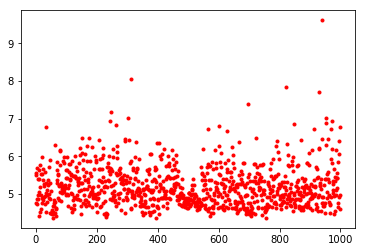

In [11]:
plt.plot(submission,"r.")